## Partial Dependence Plot
### CHAPTER 02 - *Model Explainability Methods*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

In this notebook, we will try to apply Partial Dependence plot for model explainability as part of the influence based explainability methods discussed in Chapter 2 - Model Explainability Methods

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy pdpbox scikit-learn seaborn matplotlib

### Loading the modules

In [34]:
import pandas as pd
import numpy as np
from pdpbox import pdp, get_dataset, info_plots
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import pickle
palette = 'cool'
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

### About the data

For this notebook, we are going to use the [Big Mart Sales Prediction Datasets | Kaggle](https://www.kaggle.com/shivan118/big-mart-sales-prediction-datasets). The data is used for sales prediction for Big Mart Super Market Outlets. The data is collected for the 2013 sales for 1559 different products across 10 different outlets. The datasets used might be derived and transformed datasets from original datasets. The sources of the original datasets will be mentioned and I would strongly recommend to look at the original data for more details on the data description and for a more detailed analysis.

### Loading the data

In [3]:
df = pd.read_csv('Datasets/bigmart_sales_train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
df.shape

(8523, 12)

### EDA

We will do some basic exploratory data analysis. Our main focus will be on the usage of PDP using the PDPbox framework.

In [11]:
# Let's identify the categorical and continuous variables from the data
categorical_features = ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type','Outlet_Type','Outlet_Establishment_Year','Outlet_Size']
continuous_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP']

display(df[continuous_features].describe())

for column in categorical_features:
    print('Unique values : {} = {}'.format(column, df[column].unique()))
    print('No. of unique values : {} = {}'.format(column, df[column].nunique())+'\n')

,Item_Weight,Item_Visibility,Item_MRP
count,7060.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782
std,4.643456,0.051598,62.275067
min,4.555000,0.000000,31.290000
25%,8.773750,0.026989,93.826500
50%,12.600000,0.053931,143.012800
75%,16.850000,0.094585,185.643700
max,21.350000,0.328391,266.888400


Unique values : Item_Fat_Content = ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
No. of unique values : Item_Fat_Content = 5

Unique values : Item_Type = ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
No. of unique values : Item_Type = 16

Unique values : Outlet_Location_Type = ['Tier 1' 'Tier 3' 'Tier 2']
No. of unique values : Outlet_Location_Type = 3

Unique values : Outlet_Type = ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']
No. of unique values : Outlet_Type = 4

Unique values : Outlet_Establishment_Year = [1999 2009 1998 1987 1985 2002 2007 1997 2004]
No. of unique values : Outlet_Establishment_Year = 9

Unique values : Outlet_Size = ['Medium' nan 'High' 'Small']
No. of unique values : Outlet_Size = 3



### Null or missing value check

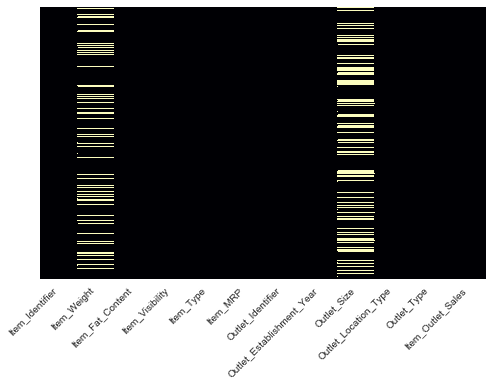

In [16]:
plt.figure(figsize=(8,5))

g = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap = 'magma')
f = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

In [21]:
def data_imputation(data):
    '''
    Method to impute the data
    '''
    df = data.copy()
    current_year = date.today().year
    df['Item_Fat_Content'] = df['Item_Fat_Content'].apply(lambda x: 'Low Fat' \
                                                          if x=='low fat'or x=='LF'or x=='Low Fat' \
                                                          else 'Regular')
    d2 =  open('Datasets/Weights/outlet_id_size.pkl','rb')
    d2 = pickle.load(d2)

    d1 =  open('Datasets/Weights/item_id_weight.pkl','rb')
    d1 = pickle.load(d1)
    
    df['Item_Weight'] = df['Item_Identifier'].apply(lambda x: d1[x])
    df['Outlet_Size'] = df['Outlet_Identifier'].apply(lambda x: d2[x])
    
    df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].apply(lambda x: current_year - x)
    return df

train_df = data_imputation(df)
print((train_df.isna().sum()*100)/len(train_df))

Item_Identifier              0.0
Item_Weight                  0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Size                  0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64


So, we observe that there are no more missing values remaining. All missing values have imputed.

### Data Correlation Check

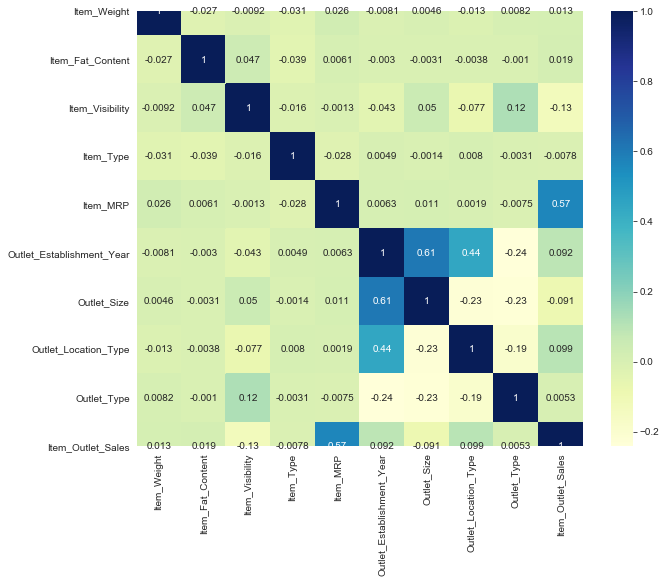

In [27]:
corr_df = train_df.copy()

for c in categorical_features:
    corr_df[c] = corr_df[c].replace(list(corr_df[c].unique()) ,[i for i in range(corr_df[c].nunique())])

plt.figure(figsize=(10,8))
sns.heatmap(corr_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Certain variable does have high correlation (>0.5) with each other. Particularly Outlet Size and Outlet Establishment year. But we are not dropping highly correlated values for the sake of simplicity. For a better model, it is better to drop highly correlated features.

### Performing Train-Test Split

In [43]:
train_df.drop(['Item_Identifier','Outlet_Identifier'],axis=1, inplace =True)
x_train,x_test,y_train,y_test = train_test_split(train_df.iloc[:,:-1],train_df.iloc[:,-1],test_size=0.2, random_state =42)

In [47]:
# Let's encode categorical features to numerical format using label_encoder
label_encoder = LabelEncoder()
variables_to_encode = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type','Outlet_Establishment_Year', 'Item_Type']

for i in variables_to_encode:
    x_train[i] = label_encoder.fit_transform(x_train[i])
    x_test[i] = label_encoder.fit_transform(x_test[i])

In [48]:
# Visualizing the encoded data
display(x_train.head())
display(x_test.tail())

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
549,9.500,1,0.035206,6,171.3448,4,1,0,1
7757,18.000,0,0.047473,9,170.5422,3,1,1,1
764,17.600,1,0.076122,10,111.7202,6,2,0,1
6867,8.325,0,0.029845,6,41.6138,3,1,1,1
2716,12.850,0,0.137228,13,155.5630,6,2,0,1


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
7205,11.800,1,0.093656,13,127.1704,6,2,0,1
3257,7.020,0,0.000000,6,148.1734,0,1,2,2
6346,14.500,1,0.041215,3,42.0454,7,0,2,1
6318,9.800,1,0.141184,0,50.5008,0,1,2,2
6339,7.905,0,0.055098,5,109.2254,3,1,1,1


Kindly note that these are very simple transformations steps that we have performed. The nature of the data is slightly complex and need more rigorous exploration and processing. For the sake of simplicity, I would skip any other complicated and rigorous transformation. But using the currently transformed data, getting a high model accuracy is difficult.

### Training the model

In [50]:
%%time
regressor = RandomForestRegressor(
    n_estimators=50, 
    criterion='mse',
    n_jobs=4,
    random_state=42
)
regressor.fit(x_train, y_train)
print(regressor.score(x_test, y_test))

0.5668592218268009
Wall time: 583 ms


As hypothesized earlier, the model performance is actually quite poor. But we don't want to focus and work more towards improving the model performance, but rather work on the model explainability using Partial Dependence Plots.

### Partial Dependence Plot

PDP can be only applied for check relationship between two features. Since, we are dealing with Sales Prediction, let's try to visualize the relationship between item visibility and item MRP as intuitively speaking, both of these features can influence the model decision making process.

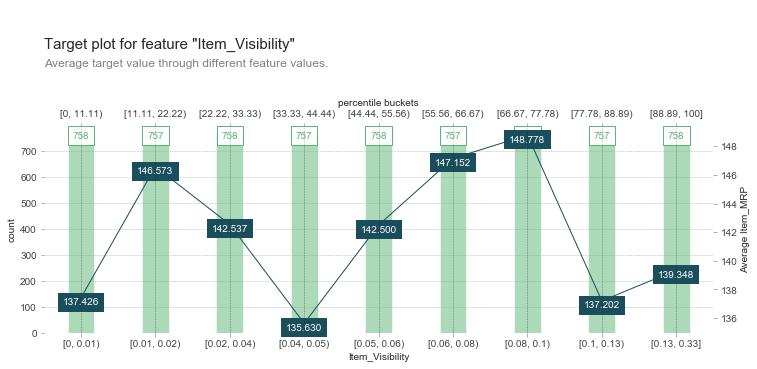

In [55]:
fig, axes, summary_df = info_plots.target_plot(
    df=x_train, feature='Item_Visibility', feature_name='Item_Visibility',
    target="Item_MRP", show_percentile=True, figsize=(12,6))

Surprisingly, we don't see any significant relation between the item visibility and item MRP.

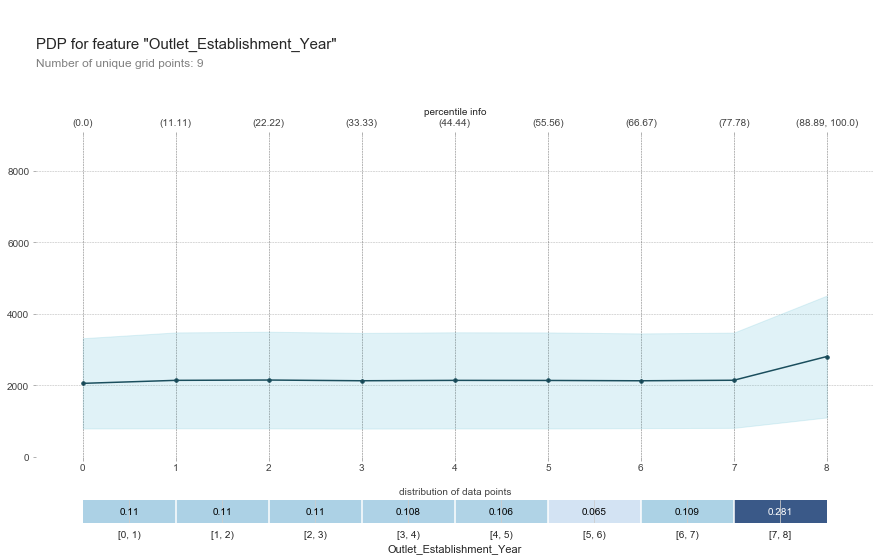

In [56]:
#PDP plot for Outlet Establishment year
pdp_est_yr = pdp.pdp_isolate(
    model=regressor, dataset=x_train, model_features=x_train.columns, feature='Outlet_Establishment_Year'
)
fig, axes = pdp.pdp_plot(pdp_est_yr, 'Outlet_Establishment_Year', plot_lines=False, center=False, frac_to_plot=0.5, plot_pts_dist=True,x_quantile=True, show_percentile=True)

The Outlet Year almost seems to have a constant effect, although during the initial years the effect seems of be higher.

Now, let's try to see if we can map any interaction between Item Weight and Item MRP.

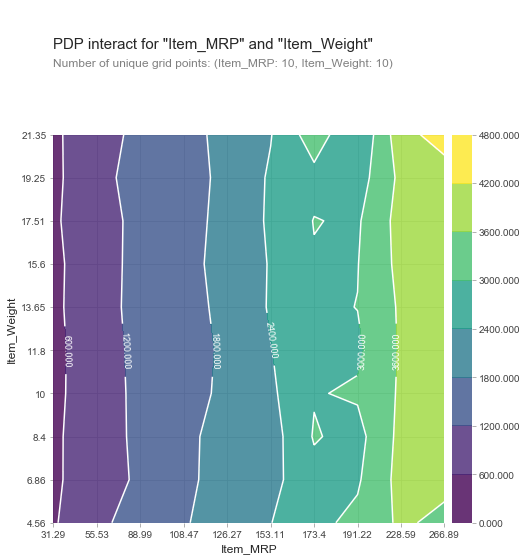

In [61]:
# PDP plot for interactions between Item Weight and Item MRP
inter_rf = pdp.pdp_interact(model=regressor,
                            dataset = x_train,
                            model_features = x_train.columns,
                            features = ['Item_MRP', 'Item_Weight'])
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['Item_MRP', 'Item_Weight'], x_quantile=True, plot_type='contour', plot_pdp=False
)

Interestingly, between Item Size and MRP there is some spikes indicating some interactions when MRP is between 172 and 190. Let's dig deeper with interaction plot with values.

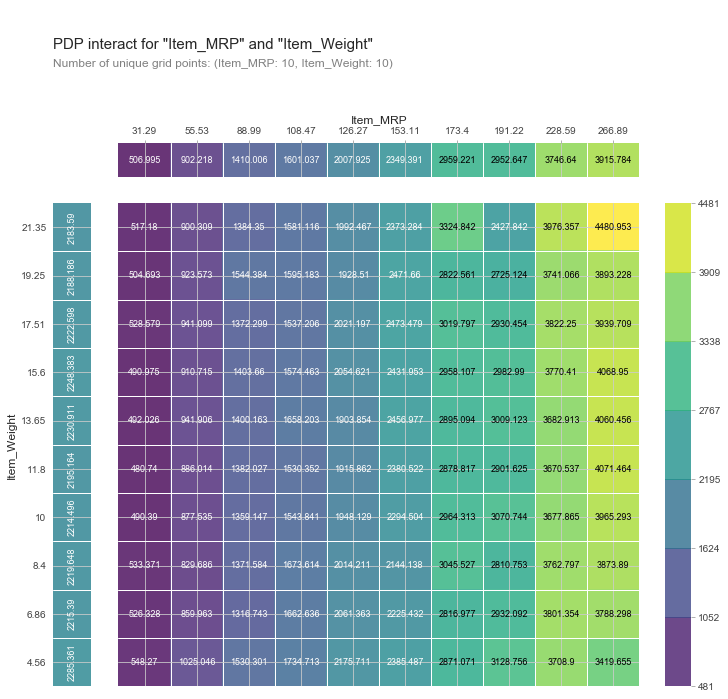

In [65]:
#Interaction PDP plot with values
fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['Item_MRP', 'Item_Weight'], x_quantile=True, plot_type='grid', plot_pdp=True
)

We can see some change in values, for the specific range. But the interactions are not extremely significant.

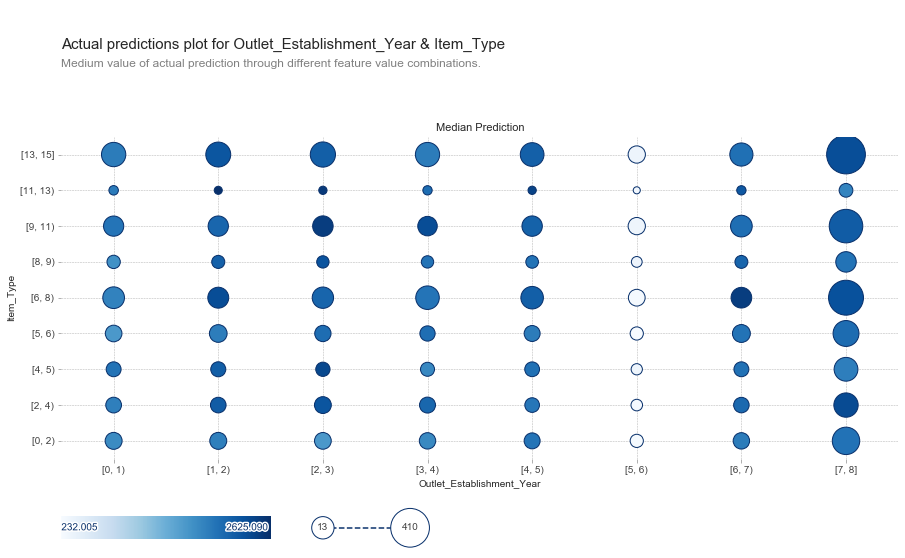

In [73]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=regressor, X=x_train, 
    features=['Outlet_Establishment_Year','Item_Type'], 
    feature_names=['Outlet_Establishment_Year','Item_Type']
)

There is some interesting observation for the outlet establishment year of 2013, which 8 years before writing this notebook (i.e. 2021). And for the range of (5,6) years of Outlet Establishment, the sales seems to be on the lower side. Otherwise the interactions are not significant.

### Final Thoughts

In this notebook, I just briefly explained how to use PDP to understand key influence of features for model explainability. Some may find PDP plots slightly difficult to interpret. I would suggest to try out more problems other than the introductory problem demonstrated in this particular notebook. Also, try the same method for classification based problems. For seasoned data scientistis, please take a look at the reference section, to refer some more resources to learn more.

### Reference

1. [PDPbox](https://github.com/SauceCat/PDPbox) - https://github.com/SauceCat/PDPbox
2. [Sales Prediction for Big Mart Outlets](https://www.kaggle.com/shivan118/big-mart-sales-prediction-datasets) - https://www.kaggle.com/shivan118/big-mart-sales-prediction-datasets
3. [Partial Dependence Plot | Interpretable Machine Learning by Christoph Molner ](https://christophm.github.io/interpretable-ml-book/pdp.html)